In [ ]:
! pip install matplotlib pandas seaborn
! pip install statsmodels
! pip install pytest
! pip install numpy nibabel nilearn neuroimagingtools
! pip install rsatoolbox
! pip install PcmPy
! pip install h5py
! pip install mat73

## Import tools

In [1]:
import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import glob
import matplotlib.patches as patches

# SET PATHS:
baseDir = '/Users/alighavampour/Desktop/Projects/bimanual_wrist/data/fMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


## ResMs ON SURFACE

This analysis can give an idea about the fit of the GLM model

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_17675/1977023799.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


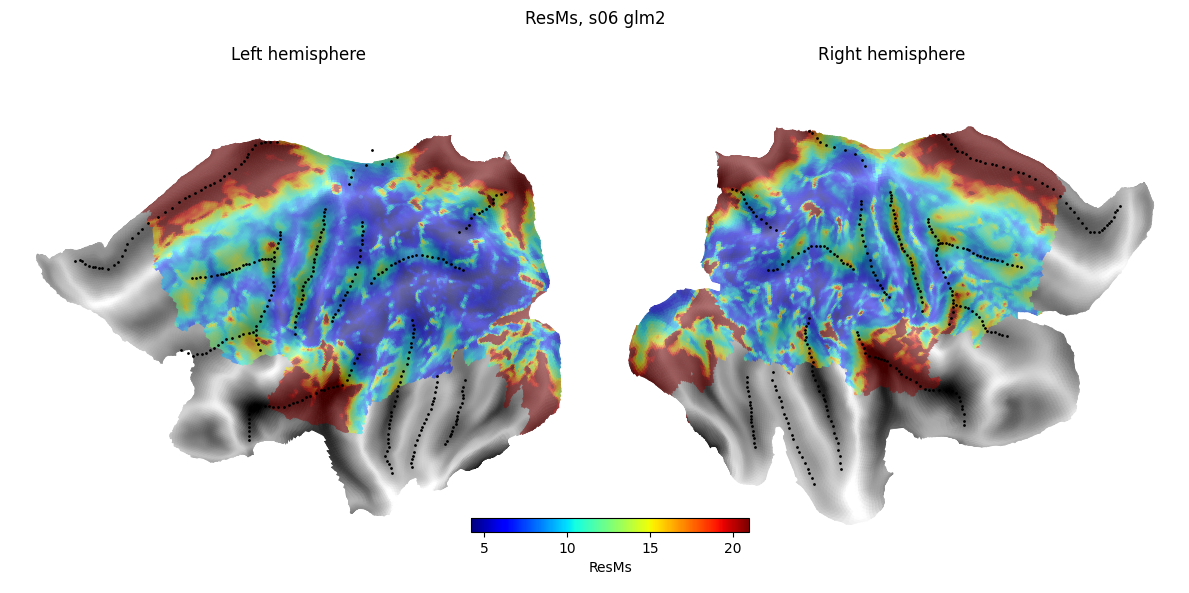

In [ ]:
sn = 6
glm = 2

ResMs = list(Path(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}')).glob(f'ResMS.nii')) 
if len(ResMs) == 0:
    raise ValueError(f'No ResMs files found for s{sn:02d} glm{glm}')

# 2. Define the relevant gifti files for both left and right hemisphere:
surf_white = [] # White -gray matter surface 
surf_pial = []  # Pial surface
surf_sulc = []  # Sulcal depth 
hemN = ['L','R']
for h,hem in enumerate(hemN):
    surf_white.append(os.path.join(baseDir,surfacewbDir, f's{sn:02d}', f's{sn:02d}.{hem}.white.32k.surf.gii'))
    surf_pial.append(os.path.join(baseDir,surfacewbDir, f's{sn:02d}', f's{sn:02d}.{hem}.pial.32k.surf.gii'))
    surf_sulc.append(os.path.join(baseDir,surfacewbDir, f's{sn:02d}', f's{sn:02d}.{hem}.sulc.32k.shape.gii'))

# Map a Nifti to the surface of left hemisphere 
DL = surf.map.vol_to_surf(ResMs,surf_pial[0], surf_white[0], excludeThres=0.9)
# Map a Nifti to the surface of right hemisphere 
DR = surf.map.vol_to_surf(ResMs,surf_pial[1],surf_white[1],  excludeThres=0.9)

D = {'L':DL, 'R':DR}

Hem = ['L', 'R']
region_names = ['?', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', '?']
Hem = ['L', 'R']
borders = {'L': './surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border',
           'R': './surfAnalysisPy/standard_mesh/fs_R/fs_LR.32k.R.border'}

# Combine data from both hemispheres
all_data = np.concatenate([D['L'].flatten(), D['R'].flatten()])
# Use percentiles to avoid outliers
vmin = np.nanpercentile(all_data,1)
vmax = np.nanpercentile(all_data, 80)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, H in zip(axs, Hem):
    plt.sca(ax)
    surf.plot.plotmap(D[H], f'fs32k_{H}',
                        underlay=None,
                        borders=borders[H],
                        cscale=[vmin, vmax],
                        cmap='jet',
                        underscale=[-1.5, 1],
                        alpha=.5,
                        new_figure=False,
                        colorbar=False,
                        # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                        )
# make colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='jet')
cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
cbar.set_label('ResMs')

axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')
fig.suptitle(f'ResMs, s{sn:02d} glm{glm}')
fig.tight_layout()
plt.savefig(f'./figures/bmw_ResMs2surf_sn{sn:02d}_glm{glm}.pdf', bbox_inches="tight")


## T-MAPS

In [ ]:
sn = 6
glm = 2
conds = ['lhand', 'rhand', 'bi']

for cond in conds:
    spmTs = list(Path(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}')).glob(f'spmT_{cond}*.nii'))
    if len(spmTs) == 0:
        raise ValueError(f'No spmT files found for s{sn:02d} glm{glm} {cond}')
    
    # 2. Define the relevant gifti files for both left and right hemisphere:
    surf_white = [] # White -gray matter surface 
    surf_pial = []  # Pial surface
    surf_sulc = []  # Sulcal depth 
    hemN = ['L','R']
    for h,hem in enumerate(hemN):
        surf_white.append(os.path.join(baseDir,surfacewbDir, f's{sn:02d}', f's{sn:02d}.{hem}.white.32k.surf.gii'))
        surf_pial.append(os.path.join(baseDir,surfacewbDir, f's{sn:02d}', f's{sn:02d}.{hem}.pial.32k.surf.gii'))
        surf_sulc.append(os.path.join(baseDir,surfacewbDir, f's{sn:02d}', f's{sn:02d}.{hem}.sulc.32k.shape.gii'))

    # Map a Nifti to the surface of left hemisphere 
    DL = surf.map.vol_to_surf(spmTs,surf_pial[0], surf_white[0], excludeThres=0.9)
    # Map a Nifti to the surface of right hemisphere 
    DR = surf.map.vol_to_surf(spmTs,surf_pial[1],surf_white[1],  excludeThres=0.9)

    D = {'L':DL, 'R':DR}

    Hem = ['L', 'R']
    region_names = ['?', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', '?']
    Hem = ['L', 'R']
    borders = {'L': './surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border',
            'R': './surfAnalysisPy/standard_mesh/fs_R/fs_LR.32k.R.border'}

    vmin = -3
    vmax = 3
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for ax, H in zip(axs, Hem):
        plt.sca(ax)
        surf.plot.plotmap(D[H].mean(axis=1), f'fs32k_{H}',
                            underlay=None,
                            borders=borders[H],
                            cscale=[vmin, vmax],
                            cmap='jet',
                            underscale=[-1.5, 1],
                            alpha=.5,
                            new_figure=False,
                            colorbar=False,
                            # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                            )
    # make colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap='jet')
    cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
    cbar.set_label('t-value')

    axs[0].set_title('Left hemisphere')
    axs[1].set_title('Right hemisphere')
    fig.suptitle(f'avg t-maps, s{sn:02d}, glm{glm}, {cond}')
    fig.tight_layout()
    plt.savefig(f'./figures/bmw_spmT2surf_sn{sn:02d}_glm{glm}_{cond}.pdf', bbox_inches="tight")


/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_17675/2433405324.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
